In [1]:
%matplotlib inline


Particle stepper
================

An example of PlasmaPy's particle stepper class, currently in need of a rewrite
for speed.


In [2]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from plasmapy.formulary import ExB_drift, gyrofrequency
from plasmapy.particles import Particle
from plasmapy.plasma.grids import CartesianGrid
from plasmapy.simulation.particle_tracker import (
    IntervalSaveRoutine,
    ParticleTracker,
    TimeElapsedStopCondition,
)

Initialize a plasma. This will be a source of electric and magnetic
fields for our particles to move in.



In [3]:
grid_length = 10
grid = CartesianGrid(-1 * u.m, 1 * u.m, num=grid_length)

Initialize the fields. We'll take B in the x direction
and E in the y direction, which gets us an E cross B drift
in the negative z direction.



In [4]:
Bx_fill = 4 * u.T
Bx = np.full(grid.shape, Bx_fill.value) * u.T

Ey_fill = 2 * u.V / u.m
Ey = np.full(grid.shape, Ey_fill.value) * u.V / u.m

grid.add_quantities(B_x=Bx, E_y=Ey)
ExB_drift(np.asarray([0, Ey_fill.value, 0]) * u.V / u.m, np.asarray([Bx_fill.value, 0, 0]) * u.T)

<Quantity [ 0. ,  0. , -0.5] m / s>

Initialize the trajectory calculation.

In [5]:
simulation = ParticleTracker(grid, verbose=True)

C:\Users\jayde\PycharmProjects\PlasmaPy\plasmapy\plasma\grids.py:189: RuntimeWarning: E_x is not specified for the provided grid.This quantity will be assumed to be zero.
  warnings.warn(
C:\Users\jayde\PycharmProjects\PlasmaPy\plasmapy\plasma\grids.py:189: RuntimeWarning: E_z is not specified for the provided grid.This quantity will be assumed to be zero.
  warnings.warn(
C:\Users\jayde\PycharmProjects\PlasmaPy\plasmapy\plasma\grids.py:189: RuntimeWarning: B_y is not specified for the provided grid.This quantity will be assumed to be zero.
  warnings.warn(
C:\Users\jayde\PycharmProjects\PlasmaPy\plasmapy\plasma\grids.py:189: RuntimeWarning: B_z is not specified for the provided grid.This quantity will be assumed to be zero.
  warnings.warn(
C:\Users\jayde\PycharmProjects\PlasmaPy\plasmapy\simulation\particle_tracker.py:397: RuntimeWarning: Fields should go to zero at edges of grid to avoid non-physical effects, but a value of 2.00E+00 V / m was found on the edge of the E_y array. Cons

We still have to initialize the particle's velocity. We'll limit ourselves to
one in the x direction, parallel to the magnetic field B -
that way, it won't turn in the z direction.



In [ ]:
x0 = [[0, 0, 0]] * u.m
v0 = [[1, 0, 0]] * u.m / u.s
particle = Particle("p+")

simulation.load_particles(x0, v0, particle)

Initialize our stop condition and save routine. We can determine a relevant
duration for the experiment by calculating the gyroperiod for the particle.

In [ ]:
particle_gyroperiod = 1 / gyrofrequency(Bx_fill, particle).to(u.Hz, equivalencies=u.dimensionless_angles())

simulation_duration = 100 * particle_gyroperiod
save_interval = particle_gyroperiod / 10

stop_condition = TimeElapsedStopCondition(simulation_duration)
save_routine = IntervalSaveRoutine(save_interval)

Run the simulation.

In [7]:
simulation.run(stop_condition=stop_condition, save_routine=save_routine)

Time remaining: 100%|██████████2.6e-07/2.6e-07 seconds
Run completed


We can take a look at the trajectory in the z direction:

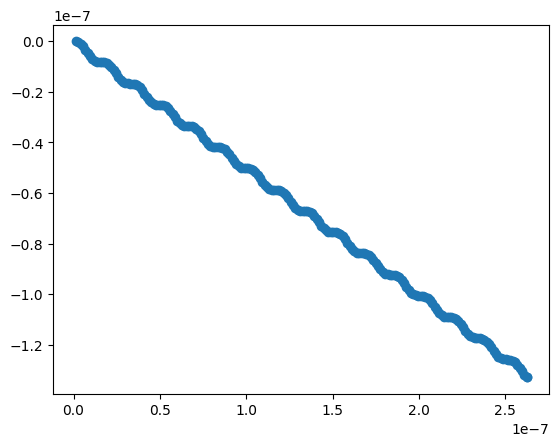

In [8]:
r_all = np.asarray(save_routine.r_all)

z_all = r_all[:, 0, 2]
t_all = np.asarray(save_routine.t_all)

plt.scatter(t_all, z_all)

or plot the shape of the trajectory in 3D:

Text(0.5, 0, 'Z')

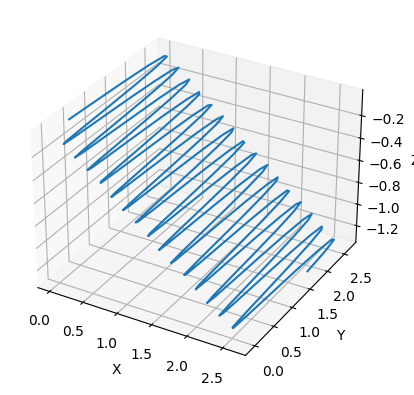

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(*r_all[:, 0,:].T)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

As a test, we calculate the mean velocity in the z direction from the
velocity:

In [10]:
v_all = np.asarray(save_routine.v_all)

v_mean = v_all[:, :, 2].mean()
print(
    f"The calculated drift velocity is {v_mean:.4f} to compare with the "
    f"expected E0/B0 = {-(Ey_fill/Bx_fill).value:.4f}"
)

The calculated drift velocity is -0.5076 to compare with the expected E0/B0 = -0.5000
